## Reflection Pattern
The steps that the workflow will carry out are:

1. **Generate an initial version (V1):**
Use a Large Language Model (LLM) to create the first version of the plotting code.

2. **Execute code and create chart:**
Run the generated code and display the resulting chart.

3. **Reflect on the output:**
Evaluate both the code and the chart using an LLM to detect areas for improvement (e.g., clarity, accuracy, design).

4. **Generate and execute improved version (V2):**
Produce a refined version of the plotting code based on reflection insights and render the enhanced chart.

In [1]:
import os
import re
import json
import base64
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt

from openai import OpenAI

In [2]:
from dotenv import load_dotenv

load_dotenv()

True

### Initialize environment and client

In [3]:
client = OpenAI(api_key=os.getenv("OPENAI_API_KEY"))

### Loading the dataset

In [4]:
df = pd.read_csv("data/coffee_sales.csv")
df.head(2)

,date,time,cash_type,card,price,coffee_name
0,2024-03-01,06:14,card,ANON-0000-0000-0001,3.87,Latte
1,2024-03-01,11:10,card,ANON-0000-0000-0002,3.87,Hot Chocolate


In [5]:
df["date"] = pd.to_datetime(df["date"], errors="coerce")
df["quarter"] = df["date"].dt.quarter
df["month"] = df["date"].dt.month
df["year"] = df["date"].dt.year

### Generate Code to Create a Chart (V1)

In [11]:
prompt = """
You are a data visualization expert.

Return your answer *strictly* in this format:

<execute_python>
# valid python code here
</execute_python>

Do not add explanations, only the tags and the code.

The code should create a visualization from a DataFrame 'df' with these columns:
- date (M/D/YY) of type datetime64
- time (HH:MM)
- cash_type (card or cash)
- card (string)
- price (number)
- coffee_name (string)
- quarter (1-4)
- month (1-12)
- year (YYYY)

User instruction: {instruction}

Requirements for the code:
1. Assume the DataFrame is already loaded as 'df'.
2. Use matplotlib for plotting.
3. Add clear title, axis labels, and legend if needed.
4. Save the figure as '{out_path_v1}' with dpi=300.
5. Do not call plt.show().
6. Close all plots with plt.close().
7. Add all necessary import python statements

Return ONLY the code wrapped in <execute_python> tags.
"""

response = client.responses.create(
    model="gpt-4",
    input=prompt.format(
        instruction="Create a plot comparing Q1 coffee sales in 2024 and 2025 using the data in coffee_sales.csv.",
        out_path_v1="chart_v1.png"
    ),
)

In [12]:
code_v1 = response.output_text

In [13]:
print(code_v1)

<execute_python>
import matplotlib.pyplot as plt

q1_2024 = df[(df["quarter"] == 1) & (df["year"] == 2024)]["price"].sum()
q1_2025 = df[(df["quarter"] == 1) & (df["year"] == 2025)]["price"].sum()

plt.bar(["Q1 2024", "Q1 2025"], [q1_2024, q1_2025])
plt.xlabel("Quarter")
plt.ylabel("Sales")
plt.title("Coffee Sales in Q1 2024 and Q1 2025")
plt.savefig('chart_v1.png', dpi=300)
plt.close()
</execute_python>


### Execute Code and Create Chart

In [14]:
match = re.search(r"<execute_python>([\s\S]*?)</execute_python>", code_v1)
initial_code = match.group(1).strip()

In [15]:
exec(initial_code, {'df': df})

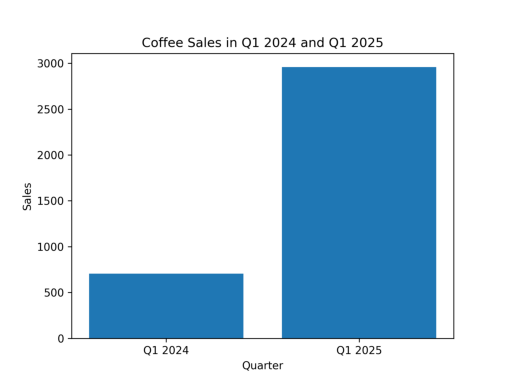

In [16]:
img = Image.open("chart_v1.png")
plt.imshow(img)
plt.axis("off")
plt.show()

### Reflect on the output

In [17]:
with open("chart_v1.png", "rb") as f:
    image_bytes = f.read()

image_b64 = base64.b64encode(image_bytes).decode("utf-8")

In [19]:
prompt = """
You are a data visualization expert.
Your task: critique the attached chart and the original code against the given instruction,
then return improved matplotlib code.

Original code (for context):
{code_v1}

OUTPUT FORMAT (STRICT):
1) First line: a valid JSON object with ONLY the "feedback" field.
Example: {{"feedback": "The legend is unclear and the axis labels overlap."}}

2) After a newline, output ONLY the refined Python code wrapped in:
<execute_python>
...
</execute_python>

3) Import all necessary libraries in the code. Don't assume any imports from the original code.

HARD CONSTRAINTS:
- Do NOT include Markdown, backticks, or any extra prose outside the two parts above.
- Use pandas/matplotlib only (no seaborn).
- Assume df already exists; do not read from files.
- Save to '{out_path_v2}' with dpi=300.
- Always call plt.close() at the end (no plt.show()).
- Include all necessary import statements.

Schema (columns available in df):
- date (M/D/YY) of type datetime64
- time (HH:MM)
- cash_type (card or cash)
- card (string)
- price (number)
- coffee_name (string)
- quarter (1-4)
- month (1-12)
- year (YYYY)

Instruction:
{instruction}
"""

In [21]:
response_2 = client.responses.create(
    model="gpt-5-mini",
    input=[
        {
            "role": "user",
            "content": [
                {
                    "type": "input_text",
                    "text": prompt.format(
                        code_v1=code_v1,
                        out_path_v2="chart_v2.png",
                        instruction="Create a plot comparing Q1 coffee sales in 2024 and 2025 using the data in coffee_sales.csv."

                    )
                },
                {
                    "type": "input_image",
                    "image_url": f"data:image/png;base64,{image_b64}"
                }
            ],
        }
    ],
)

content_2 = (response_2.output_text or "").strip()

In [22]:
lines = content_2.strip().splitlines()
lines

['{"feedback": "Code correctly sums Q1 sales but the chart can be improved: missing currency formatting on the y-axis, no value labels on bars, no percent-change annotation, default styling (spines, colors) is plain, and the aggregation could be made more robust if a year is missing. Use clearer labels, formatted tick labels, gridlines, and annotate exact values and percent change."}',
 '',
 '<execute_python>',
 'import pandas as pd',
 'import matplotlib.pyplot as plt',
 'import matplotlib.ticker as mticker',
 '',
 '# Aggregate Q1 sales for 2024 and 2025 (robust to missing years)',
 'year_list = [2024, 2025]',
 'q1 = df[(df["quarter"] == 1) & (df["year"].isin(year_list))].groupby("year")["price"].sum()',
 'values = [float(q1.get(yr, 0.0)) for yr in year_list]',
 'labels = [f"Q1 {yr}" for yr in year_list]',
 '',
 '# Compute percent change (from 2024 to 2025) when possible',
 'v2024, v2025 = values',
 'pct_change = None',
 'if v2024 > 0:',
 '    pct_change = (v2025 - v2024) / v2024 * 100

In [23]:
json_line = lines[0].strip() if lines else ""
feedback_json = json.loads(json_line)
feedback = str(json.loads(json_line).get("feedback", "")).strip()
print(feedback)

Code correctly sums Q1 sales but the chart can be improved: missing currency formatting on the y-axis, no value labels on bars, no percent-change annotation, default styling (spines, colors) is plain, and the aggregation could be made more robust if a year is missing. Use clearer labels, formatted tick labels, gridlines, and annotate exact values and percent change.


In [24]:
match_2 = re.search(r"<execute_python>([\s\S]*?)</execute_python>", content_2)
refined_code = match_2.group(1).strip() if match_2 else ""
print(refined_code)

import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker

# Aggregate Q1 sales for 2024 and 2025 (robust to missing years)
year_list = [2024, 2025]
q1 = df[(df["quarter"] == 1) & (df["year"].isin(year_list))].groupby("year")["price"].sum()
values = [float(q1.get(yr, 0.0)) for yr in year_list]
labels = [f"Q1 {yr}" for yr in year_list]

# Compute percent change (from 2024 to 2025) when possible
v2024, v2025 = values
pct_change = None
if v2024 > 0:
    pct_change = (v2025 - v2024) / v2024 * 100

# Plot
fig, ax = plt.subplots(figsize=(8, 6))
colors = ["#1f77b4", "#ff7f0e"]
bars = ax.bar(labels, values, color=colors, edgecolor="black", linewidth=0.6)

# Format y-axis as currency
ax.yaxis.set_major_formatter(mticker.FuncFormatter(lambda x, pos: f'${x:,.0f}'))

# Add value labels on top of bars
for bar in bars:
    h = bar.get_height()
    ax.annotate(f'${h:,.0f}', xy=(bar.get_x() + bar.get_width() / 2, h),
                xytext=(0, 6), textcoords="offset point

### Generate and Execute Improved Version (V2)

In [25]:
exec(refined_code, {"df": df})

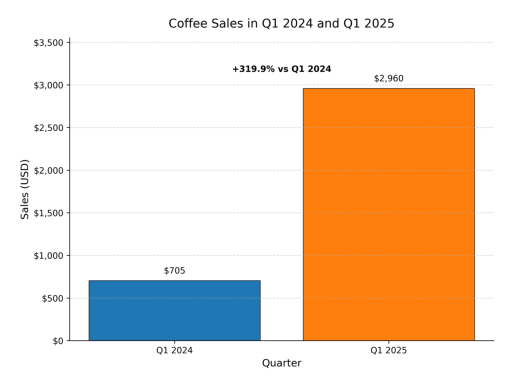

In [26]:
img_2 = Image.open("chart_v2.png")
plt.imshow(img_2)
plt.axis("off")
plt.show()